In [5]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
sns.set(
    font_scale =1,
    style      ="whitegrid",
    rc         ={'figure.figsize':(9,6)}
)

In [7]:
df = pd.read_csv('sample_superstore.csv', parse_dates=['order_date','ship_date'])

**Построение когортного анализа и расчет retention rate. Пошаговая инструкция**

In [8]:
# шаг 0.1. Отфильтровываю временной период нужный для когортного анализа
df = df.query("order_date < '2016-12-15'")

In [9]:
# шаг 0.2. Буду считать когорты по месяцам
df['order_date'] = df['order_date'].dt.to_period('M')

In [10]:
# шаг 1. Оставляю только столбцы с id клиента, и датой заказа
df = df[['customer_id','order_date']]

In [11]:
df.head(3)

,customer_id,order_date
5,BH-11710,2016-06
6,BH-11710,2016-06
7,BH-11710,2016-06


In [12]:
# шаг 2. Датой первой покупки каждого id клиента присваиваю когорту
df['cohort_month'] = df.groupby('customer_id')['order_date'].transform('min')

In [13]:
df.head(3)

,customer_id,order_date,cohort_month
5,BH-11710,2016-06,2016-06
6,BH-11710,2016-06,2016-06
7,BH-11710,2016-06,2016-06


In [14]:
# шаг 3. Группирую по когорте, и считаю количество размер когорты
df['cohort_size'] = df.groupby('cohort_month')['customer_id'].transform('nunique')

In [15]:
df.head(3)

,customer_id,order_date,cohort_month,cohort_size
5,BH-11710,2016-06,2016-06,48
6,BH-11710,2016-06,2016-06,48
7,BH-11710,2016-06,2016-06,48


In [16]:
# шаг 4. Группирую по когорте и каждому дню, и считаю количество клиентов в последующие дни
df['day_unique'] = df.groupby(['cohort_month','order_date'], as_index=False)['customer_id'].transform('nunique')

In [17]:
df.head(3)

,customer_id,order_date,cohort_month,cohort_size,day_unique
5,BH-11710,2016-06,2016-06,48,48
6,BH-11710,2016-06,2016-06,48,48
7,BH-11710,2016-06,2016-06,48,48


In [18]:
# шаг 5. Поскольку клиент совершает больше чем одну покупку в месяце (а мне достаточно одной),
# образуются дубликаты от которых нужно избавится
df = df.drop_duplicates(subset=['order_date','cohort_month','cohort_size','day_unique'], keep='first')

In [19]:
df.head(3)

,customer_id,order_date,cohort_month,cohort_size,day_unique
5,BH-11710,2016-06,2016-06,48,48
16,PK-19075,2016-11,2016-11,62,62
17,AG-10270,2016-05,2016-05,56,56


In [20]:
# шаг 6. Расчитываю retention rate
df['retention'] = round(df.day_unique/df.cohort_size*100, 2)

In [21]:
df.tail(3)

,customer_id,order_date,cohort_month,cohort_size,day_unique,retention
6169,MM-17920,2016-08,2016-01,32,4,12.50
7065,RS-19765,2016-12,2016-04,56,1,1.79
8694,CR-12625,2016-08,2016-06,48,2,4.17


In [22]:
# шаг 7. Расчитываю количество месяцев прошедших с образования когорты
df['month_order'] = (df['order_date'] - df['cohort_month']).apply(lambda x: x.n)

In [23]:
df.tail(3)

,customer_id,order_date,cohort_month,cohort_size,day_unique,retention,month_order
6169,MM-17920,2016-08,2016-01,32,4,12.50,7
7065,RS-19765,2016-12,2016-04,56,1,1.79,8
8694,CR-12625,2016-08,2016-06,48,2,4.17,2


In [24]:
# шаг 8. Строю сводную таблицу. В индексе названия когорт, в столбцах порядковые номера месяцев, в значениях retention
retention = df.pivot(index='cohort_month', columns='month_order', values='retention')
retention

month_order,0,1,2,3,4,5,6,7,8,9,10,11
cohort_month,,,,,,,,,,,,
2016-01,100.0,9.38,NaN,6.25,6.25,NaN,6.25,12.50,15.62,9.38,21.88,6.25
2016-02,100.0,16.67,8.33,4.17,NaN,8.33,8.33,12.50,12.50,16.67,4.17,NaN
2016-03,100.0,6.15,3.08,12.31,10.77,NaN,10.77,7.69,12.31,3.08,NaN,NaN
2016-04,100.0,10.71,3.57,7.14,5.36,14.29,10.71,16.07,1.79,NaN,NaN,NaN
2016-05,100.0,8.93,8.93,7.14,17.86,3.57,21.43,8.93,NaN,NaN,NaN,NaN
2016-06,100.0,2.08,4.17,8.33,4.17,18.75,6.25,NaN,NaN,NaN,NaN,NaN
2016-07,100.0,13.64,11.36,NaN,11.36,4.55,NaN,NaN,NaN,NaN,NaN,NaN
2016-08,100.0,16.33,6.12,22.45,6.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09,100.0,13.24,13.24,8.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


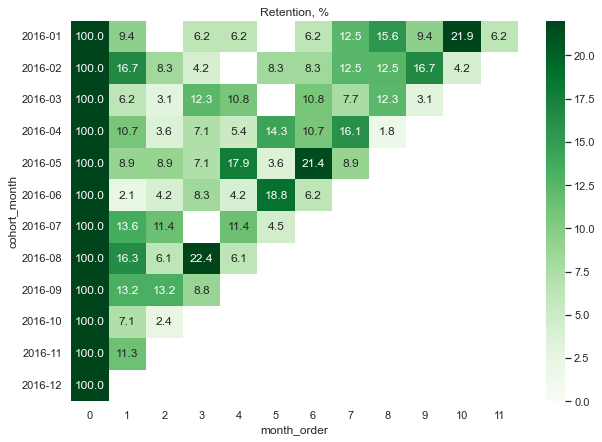

In [25]:
# шаг 9. Строю хитплот
ret_max = df.query("retention != 100").retention.max().round() 

plt.rcParams['font.size'] = '12'
plt.figure(figsize=(10,7))
plt.title('Retention, %')
ax = sns.heatmap(data=retention, annot=True, vmin=0, vmax=ret_max ,cmap='Greens', fmt=".1f")
ax.set_yticklabels(retention.index)
ax.set_xticklabels(retention.columns)
fig=ax.get_figure()

plt.show()

**Может возникнуть следующая ситуация: когда сводная таблица когортного анализ построена без расчета retention, в абсолютных значениях**

In [26]:
df2 = pd.read_csv('sample_superstore.csv', parse_dates=['order_date','ship_date'])

In [27]:
# шаг 0-3 повторяются
df2 = df2.query("order_date < '2016-12-15'")
df2['order_date'] = df2['order_date'].dt.to_period('M')
df2 = df2[['customer_id','order_date']]
df2['cohort_month'] = df2.groupby('customer_id')['order_date'].transform('min')

In [28]:
df2.head(5)

,customer_id,order_date,cohort_month
5,BH-11710,2016-06,2016-06
6,BH-11710,2016-06,2016-06
7,BH-11710,2016-06,2016-06
8,BH-11710,2016-06,2016-06
9,BH-11710,2016-06,2016-06


In [29]:
# шаг 4.1. Расчитываю количество клиентов когорты для каждого дня
df2['day_cohort'] = df2.groupby(['cohort_month','order_date'], as_index=False)['customer_id'].transform('nunique')

In [30]:
df2.head(3)

,customer_id,order_date,cohort_month,day_cohort
5,BH-11710,2016-06,2016-06,48
6,BH-11710,2016-06,2016-06,48
7,BH-11710,2016-06,2016-06,48


In [31]:
# шаг 5.1. Удаляю дубликакты
df2 = df2.drop_duplicates(subset=['order_date','cohort_month','day_cohort'], keep='first')

In [32]:
df2.head(3)

,customer_id,order_date,cohort_month,day_cohort
5,BH-11710,2016-06,2016-06,48
16,PK-19075,2016-11,2016-11,62
17,AG-10270,2016-05,2016-05,56


In [33]:
# шаг 6.1. Строю сводную таблицу
cohorts = df2.pivot(index='cohort_month', columns='order_date', values='day_cohort')

In [34]:
cohorts

order_date,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12
cohort_month,,,,,,,,,,,,
2016-01,32.0,3.0,NaN,2.0,2.0,NaN,2.0,4.0,5.0,3.0,7.0,2.0
2016-02,NaN,24.0,4.0,2.0,1.0,NaN,2.0,2.0,3.0,3.0,4.0,1.0
2016-03,NaN,NaN,65.0,4.0,2.0,8.0,7.0,NaN,7.0,5.0,8.0,2.0
2016-04,NaN,NaN,NaN,56.0,6.0,2.0,4.0,3.0,8.0,6.0,9.0,1.0
2016-05,NaN,NaN,NaN,NaN,56.0,5.0,5.0,4.0,10.0,2.0,12.0,5.0
2016-06,NaN,NaN,NaN,NaN,NaN,48.0,1.0,2.0,4.0,2.0,9.0,3.0
2016-07,NaN,NaN,NaN,NaN,NaN,NaN,44.0,6.0,5.0,NaN,5.0,2.0
2016-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.0,8.0,3.0,11.0,3.0
2016-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0,9.0,9.0,6.0


**Метод пересчета сводной таблицы из абсолютных значений в относительные (retention_rate)**

In [35]:
# шаг 7.1. Вынимаю максимальное число клиентов для каждой когорты из сводной таблицы
# Создаю таблицу с информацией о размере когорт
df2_size = cohorts.max(axis=1).to_frame(name='cohort_size')

In [37]:
df2_size.head(3)

,cohort_size
cohort_month,
2016-01,32.0
2016-02,24.0
2016-03,65.0


In [38]:
# шаг 8.2. Расчет retention_rate на основе существующей сводной таблицы
# нужно создать копию
retention2 = cohorts.copy()
for index, row in retention2.iterrows():
    retention2.loc[index] = round(row / df2_size.loc[index, 'cohort_size'] * 100, 2)

In [39]:
retention2

order_date,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12
cohort_month,,,,,,,,,,,,
2016-01,100.0,9.38,NaN,6.25,6.25,NaN,6.25,12.50,15.62,9.38,21.88,6.25
2016-02,NaN,100.00,16.67,8.33,4.17,NaN,8.33,8.33,12.50,12.50,16.67,4.17
2016-03,NaN,NaN,100.00,6.15,3.08,12.31,10.77,NaN,10.77,7.69,12.31,3.08
2016-04,NaN,NaN,NaN,100.00,10.71,3.57,7.14,5.36,14.29,10.71,16.07,1.79
2016-05,NaN,NaN,NaN,NaN,100.00,8.93,8.93,7.14,17.86,3.57,21.43,8.93
2016-06,NaN,NaN,NaN,NaN,NaN,100.00,2.08,4.17,8.33,4.17,18.75,6.25
2016-07,NaN,NaN,NaN,NaN,NaN,NaN,100.00,13.64,11.36,NaN,11.36,4.55
2016-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.00,16.33,6.12,22.45,6.12
2016-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.00,13.24,13.24,8.82


**Метод: когда вместо календарных месяцев в столбцах, нужно сделать порядковые месяцы после создания когорт (разворот таблицы)**

In [40]:
# шаг 9.2. Раскрываю сводную таблицу, в обычную пандасерию и создаю датафрейм 
retention3 = retention2.stack(level=0).rename('retention').to_frame().reset_index()

In [41]:
retention3.head(3)

,cohort_month,order_date,retention
0,2016-01,2016-01,100.00
1,2016-01,2016-02,9.38
2,2016-01,2016-04,6.25


In [42]:
# шаг 10.2. Расчитываю количество месяцев прошедших с образования когорты
retention3['month_order'] = (retention3['order_date'] - retention3['cohort_month']).apply(lambda x: x.n)

In [43]:
retention3.head(3)

,cohort_month,order_date,retention,month_order
0,2016-01,2016-01,100.00,0
1,2016-01,2016-02,9.38,1
2,2016-01,2016-04,6.25,3


In [44]:
# шаг 11.2. Строю сводную таблицу
retention3 = retention3.pivot(index='cohort_month', columns='month_order', values='retention')

In [45]:
retention3

month_order,0,1,2,3,4,5,6,7,8,9,10,11
cohort_month,,,,,,,,,,,,
2016-01,100.0,9.38,NaN,6.25,6.25,NaN,6.25,12.50,15.62,9.38,21.88,6.25
2016-02,100.0,16.67,8.33,4.17,NaN,8.33,8.33,12.50,12.50,16.67,4.17,NaN
2016-03,100.0,6.15,3.08,12.31,10.77,NaN,10.77,7.69,12.31,3.08,NaN,NaN
2016-04,100.0,10.71,3.57,7.14,5.36,14.29,10.71,16.07,1.79,NaN,NaN,NaN
2016-05,100.0,8.93,8.93,7.14,17.86,3.57,21.43,8.93,NaN,NaN,NaN,NaN
2016-06,100.0,2.08,4.17,8.33,4.17,18.75,6.25,NaN,NaN,NaN,NaN,NaN
2016-07,100.0,13.64,11.36,NaN,11.36,4.55,NaN,NaN,NaN,NaN,NaN,NaN
2016-08,100.0,16.33,6.12,22.45,6.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09,100.0,13.24,13.24,8.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
